## Objective
Use gradient ascent to create a trace that causes the model to maximize location score

In [1]:
%load_ext autoreload

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

%autoreload 2
from src import meta, utils
from src.data import Recording
from src.model import ModelSpikeSorter

In [3]:
# Load model
MODEL_PATH = meta.ORGANOID_MODELS[5]
##
model = ModelSpikeSorter.load(MODEL_PATH)

In [ ]:
# Get piece of noise
REC_PATH = meta.ORGANOID[0]
##
rec = Recording(REC_PATH, model.sample_size, 0, gain_to_uv=meta.GAIN_TO_UV)
# utils.random_seed(10) 
# trace_og = rec.get_sample()
# trace_og = trace_og - np.median(trace_og)
# plt.plot(trace_og)
# plt.show()

Using random seed 12
Iter 1: 0.0%, grad: -0.36865234375
Iter 2: 0.0%, grad: -0.39599609375
Iter 3: 0.3%, grad: -0.51953125
Iter 4: 5.8%, grad: -0.487060546875
Iter 5: 30.9%, grad: -0.404541015625
Iter 6: 62.2%, grad: -0.304443359375
Iter 7: 79.4%, grad: -0.25048828125
Iter 8: 87.2%, grad: -0.1871337890625
Iter 9: 91.8%, grad: -0.1729736328125
Iter 10: 94.1%, grad: -0.1409912109375
Iter 11: 95.6%, grad: -0.13330078125
Iter 12: 96.8%, grad: -0.1260986328125
Iter 13: 97.4%, grad: -0.10400390625
Iter 14: 97.8%, grad: -0.0987548828125
Iter 15: 98.2%, grad: -0.0965576171875
Iter 16: 98.5%, grad: -0.09307861328125
Iter 17: 98.7%, grad: -0.09356689453125
Iter 18: 98.9%, grad: -0.09136962890625
Iter 19: 99.0%, grad: -0.08648681640625
Iter 20: 99.1%, grad: -0.0849609375
Iter 21: 99.2%, grad: -0.08319091796875
Iter 22: 99.3%, grad: -0.08294677734375
Iter 23: 99.4%, grad: -0.0838623046875
Iter 24: 99.4%, grad: -0.08367919921875
Iter 25: 99.5%, grad: -0.08624267578125
Iter 26: 99.6%, grad: -0.08569

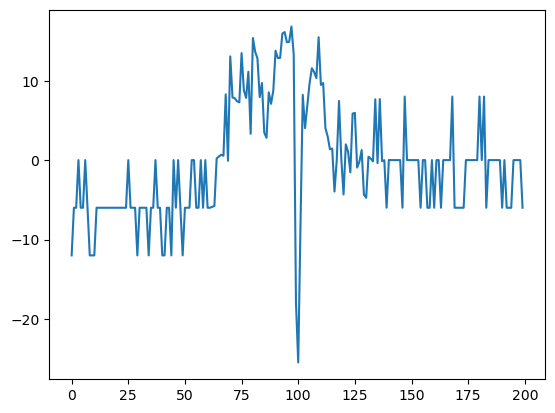

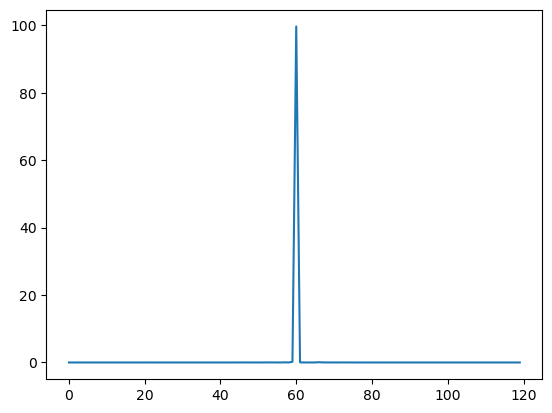

In [90]:
# Perform gradient ascent

# # Iter 18: 100.0%, grad: -0.091552734375
# utils.random_seed(10) 
# trace_og = rec.get_sample()
# trace_og = trace_og - np.median(trace_og)
# NUM_ITER = 18  # Number of iterations for gradient ascent
# LR = 5e1  # Learning rate for gradient ascent

# # Iter 5: 30.9%, grad: -0.404541015625
# utils.random_seed(12) 
# trace_og = rec.get_sample()
# trace_og = trace_og - np.median(trace_og)
# NUM_ITER = 5  # Number of iterations for gradient ascent
# LR = 0.5e1  # Learning rate for gradient ascent

# Iter 30: 99.7%, grad: -0.08538818359375
utils.random_seed(12) 
trace_og = rec.get_sample()
trace_og = trace_og - np.median(trace_og)
NUM_ITER = 30  # Number of iterations for gradient ascent
LR = 0.5e1  # Learning rate for gradient ascent

LOC_ASCEND = 100  # Location of gradient ascent (relative to input window)
##
torch.manual_seed(231)
trace = torch.tensor(trace_og[None, None, :], dtype=torch.float16, device="cuda").requires_grad_()

idx_ascend = model.loc_to_logit(LOC_ASCEND)
for i in range(NUM_ITER):
    trace.grad = None

    output = model(trace)
    # output = torch.sigmoid(output)
    output[0, idx_ascend].backward()
    with torch.no_grad():
        trace += LR * trace.grad
    
    output = model(trace)
    print(f"Iter {i+1}: {torch.sigmoid(output[0, idx_ascend])*100:.1f}%, grad: {trace.grad[0, 0, LOC_ASCEND]}")
    # print(f"Iter {i+1}: {output[0, idx_ascend]*100:.1f}%, grad: {trace.grad[0, 0, LOC_ASCEND]}")
        
with torch.no_grad():
    output = model(trace)
    pred = model.outputs_to_preds(output)[0][0]
    output = output[0, :]
    probs = torch.torch.sigmoid(output).detach().cpu().numpy() * 100
    trace = trace[0, 0, :].detach().cpu().numpy()

plt.plot(trace)
#plt.axvline(LOC_ASCEND, color="black", linestyle="dashed")
plt.show()

plt.plot(probs)
plt.show()

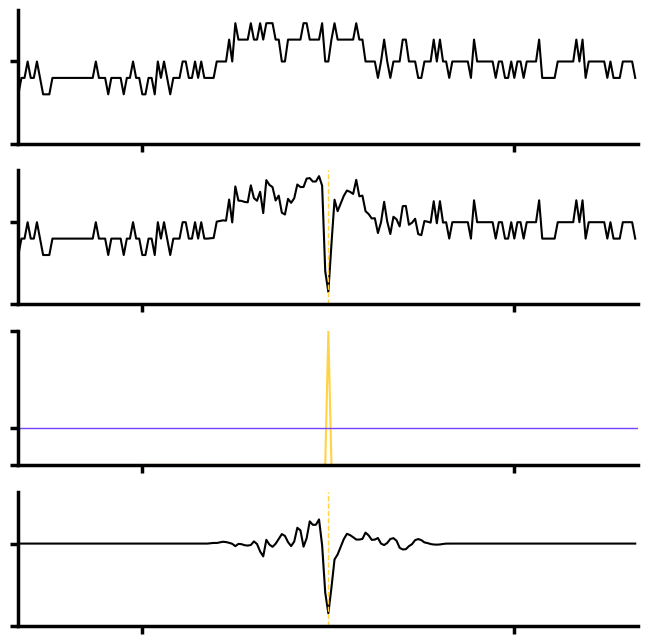

In [91]:
from pathlib import Path
SVG_PATH = "/data/MEAprojects/RT-Sort/figures/supplementary/spike_gradient_ascent/mea1.svg"
SVG_PATH = Path(SVG_PATH)

TICKS_PATH = SVG_PATH.parent / f"{SVG_PATH.name.split('.')[0]}_ticks.txt"  # Where to save ticks
SVG_PATH.parent.mkdir(exist_ok=True, parents=True)
SHOW = True

XTICKS = [40, 160] # [0, 100, 200]
XLIM = [0, 200]
YTICKS_PERCENT = [0, 27.5, 100]
YTICKS_UV = [0, -30] # [0, -100]

fig, axes = plt.subplots(4, 1, figsize=(8, 8))
a0, a1, a2, a3 = axes

a0.plot(trace_og, color="black")

a1.plot(trace, color="black")

a2.plot(np.arange(len(probs)) + model.buffer_front_sample, probs, color="#ffd343")
a2.axhline(model.get_loc_prob_thresh(), color="#7542ff", linewidth=1)
a2.set_ylim(0, 100)

a3.plot(trace - trace_og, color="black")

a1.axvline(pred, color="#ffd343", linewidth=1, linestyle="dashed")
a3.axvline(pred, color="#ffd343", linewidth=1, linestyle="dashed")

for ax in axes:
    ax.set_xlim(0, 200)
    
    # Hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Increase thickness of the bottom and left spines
    ax.spines["bottom"].set_linewidth(2.5)
    ax.spines["left"].set_linewidth(2.5)

    # Increase thickness of tick marks
    ax.tick_params(axis='both', direction='out', length=6, width=2.5, colors='black')

    # Hide labels
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    # Update ticks
    if XTICKS is not None:
        ax.set_xticks(XTICKS, [''] * len(XTICKS))
        if XLIM is None:
            ax.set_xlim(XTICKS[0], XTICKS[-1])
        else:
            ax.set_xlim(*XLIM)
        ax.set_yticks([])

ylim = a1.get_ylim()
a0.set_ylim(ylim)
a3.set_ylim(ylim)
a2.set_yticks(YTICKS_PERCENT, [''] * len(YTICKS_PERCENT))
for ax in (a0, a1, a3):
    ax.set_yticks(YTICKS_UV, [''] * len(YTICKS_UV))

plt.savefig(SVG_PATH, format="svg")
# Save ticks
with open(TICKS_PATH, "w") as file:
    file.write(f"x-ticks: {XTICKS} frames\ny-ticks for 1st, 2nd, 3rd plots: {YTICKS_UV} microvolts\ny-ticks for last plot: {YTICKS_PERCENT}%")

plt.show()